In [1]:
import pandas as pd
import numpy as np
from chp5_objs import CBOWVectorizer, CBOWDataset
import utils
from torch.utils.data import DataLoader
from torch import nn
import torch
import torch.functional as F
import matplotlib.pyplot as plt

In [2]:
embedding_file = '../data/glove.6B.100d.txt'

In [3]:
frank_df = pd.read_csv('../data/frank_df.csv')
frank_df.head()

,sent_id,target,context,split
0,0,st.,"['<PAD>', '<PAD>', 'petersburgh', 'dec.']",test
1,0,petersburgh,"['<PAD>', 'st.', 'dec.', '11th']",test
2,0,dec.,"['st.', 'petersburgh', '11th', '17—.']",test
3,0,11th,"['petersburgh', 'dec.', '17—.', 'you']",test
4,0,17—.,"['dec.', '11th', 'you', 'will']",test


In [4]:
dataset = CBOWDataset.load_dataset_and_make_vectorizer(frank_df)

input dataset: 74,839 records
context vocab: 7052 unique tokens
target vocab:  7050 unique tokens
torch device:  cpu


In [5]:
embeddings = utils.make_embedding_matrix(embedding_file, 
                                         dataset.vectorizer.context_vocab._token_to_index)

embedding dimension: 100 
original embedding : 400,000 words
final embedding    : 7,052 words
new embeddings     : 231 words


In [6]:
class CBOWClassifier(nn.Module):
    def __init__(self, in_vocab_size, embeddings, out_vocab_size, padding_idx):
        super(CBOWClassifier, self).__init__()
        self.embedding_dim = embeddings.shape[1]
        self.embedding = nn.Embedding(in_vocab_size, self.embedding_dim, 
                                      padding_idx=padding_idx,
                                      _weight=torch.tensor(embeddings))
        self.fc = nn.Linear(self.embedding_dim, out_vocab_size)
        
    def forward(self, input, apply_softmax=False):
        emb = self.embedding(input).sum(dim=1)
        out = self.fc(emb.float())
        if apply_softmax:
            out = F.softmax(out, dim=1)
        return out

In [7]:
model = CBOWClassifier(in_vocab_size=len(dataset.vectorizer.context_vocab),
                       embeddings=embeddings,
                       out_vocab_size=len(dataset.vectorizer.target_vocab),
                       padding_idx=dataset.vectorizer.context_vocab.lookup_token('<PAD>'))

In [8]:
model

CBOWClassifier(
  (embedding): Embedding(7052, 100, padding_idx=1)
  (fc): Linear(in_features=100, out_features=7050, bias=True)
)

In [9]:
EPOCHS = 10
LR = 0.001
BATCH_SIZE = 64

In [10]:
def epoch_iteration(dataset, optim, batch_size, split='train'):
    
    dataset.set_split()
    
    if split == 'train': 
        model.train()
    else:
        model.eval()
    
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=True, drop_last=False)

    ce_loss = nn.CrossEntropyLoss(reduction='sum')
    
    running_loss = 0
    
    for i, data in enumerate(dataloader):
        
        model.zero_grad()
        pred = model(data['context'])
        loss = ce_loss(pred, data['target'])

        loss.backward()
        
        running_loss += loss.item()

        if split == 'train': optim.step()
            
    return running_loss / (len(dataset))

In [11]:
hist = []

In [12]:
optim = torch.optim.Adam(params=model.parameters(), lr=LR)

for epoch in range(EPOCHS):
    train_loss = epoch_iteration(dataset, optim, BATCH_SIZE, 'train')
    valid_loss = epoch_iteration(dataset, optim, BATCH_SIZE, 'valid')
    print('{}/{} : {} : {}'.format(epoch+1, EPOCHS, train_loss, valid_loss))
    hist.append((train_loss, valid_loss))


1/10 : 6.777246822611713 : 5.760029727344672
2/10 : 5.6697438434566925 : 5.091267908657975
3/10 : 5.10810964910706 : 4.577096946135238
4/10 : 4.642732204388171 : 4.127319247453931
5/10 : 4.2322970402988735 : 3.736710498791525
6/10 : 3.865671950972108 : 3.388460769397412
7/10 : 3.5380095831198317 : 3.085978721776679
8/10 : 3.2447908262655356 : 2.8251855272582507
9/10 : 2.9875727009051705 : 2.5953074060934638
10/10 : 2.7608919791941795 : 2.3947003919808227


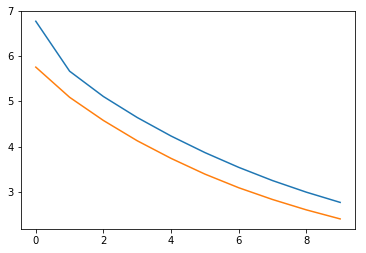

In [13]:
plt.plot(np.array(hist)[:,0])
plt.plot(np.array(hist)[:,1])
plt.show()